## Sensitivity: early and late
There was a decrease in the first half of the year while after session 10 it started increasing again, 
separating those is instersting theoretically

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
os.chdir(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
#import cov_model_management as mm
sys.path.append(os.path.join(root_dir, "covid-fear", "lib")) 
import bammm.bammm as mm
import patsy
from IPython import display

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
# hyperparameters
corr_type = "spearman" 
factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
no_trait_factors = 5
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]

### Model 0: traits + severity + traits * severity + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + session + (session|subject) 
$$

Model F1_severity_noslope_early_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.122  0.014   0.095    0.148      0.000   
TF1_Worry                          -0.024  0.122  -0.248    0.206      0.004   
TF2_Self_Worth                      0.031  0.142  -0.234    0.302      0.005   
TF3_Catastrophizing                 0.232  0.133  -0.020    0.481      0.005   
TF4_Anxiety                         0.054  0.131  -0.190    0.309      0.005   
TF5_Depression                     -0.005  0.142  -0.275    0.265      0.005   
state_severity:TF1_Worry            0.034  0.015   0.006    0.062      0.000   
state_severity:TF2_Self_Worth      -0.007  0.017  -0.039    0.026      0.000   
state_severity:TF3_Catastrophizing -0.020  0.016  -0.051    0.010      0.000   
state_severity:TF4_Anxiety         -0.022  0.016  -0.051    0.007      0.000   
state_severity:TF5_Depression      -0.007  0.017  -0.038    0.025      0.000   
session                            -0.047  0.004  -0.054   -0.040      0.000   
1|PROLIFICID_sigma                  1.849  0.078   1.706    1.998      0.002   
session|PROLIFICID_sigma            0.049  0.003   0.043    0.054      0.000   
F1_Close_Person_Worry_sigma         0.301  0.004   0.293    0.310      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   18303.0    9986.0    1.0  
TF1_Worry                             0.003     792.0    1762.0    1.0  
TF2_Self_Worth                        0.003     868.0    1595.0    1.0  
TF3_Catastrophizing                   0.003     822.0    1570.0    1.0  
TF4_Anxiety                           0.004     694.0    1242.0    1.0  
TF5_Depression                        0.003     928.0    1767.0    1.0  
state_severity:TF1_Worry              0.000   19475.0   10115.0    1.0  
state_severity:TF2_Self_Worth         0.000   17614.0   10491.0    1.0  
state_severity:TF3_Catastrophizing    0.000   17452.0   10349.0    1.0  
state_severity:TF4_Anxiety            0.000   18430.0    9657.0    1.0  
state_severity:TF5_Depression         0.000   17363.0   10393.0    1.0  
session                               0.000   11755.0    9547.0    1.0  
1|PROLIFICID_sigma                    0.002    1282.0    2484.0    1.0  
session|PROLIFICID_sigma              0.000    7907.0    8948.0    1.0  
F1_Close_Person_Worry_sigma           0.000   11822.0    9126.0    1.0

Model F1_severity_noslope_late_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     -0.009  0.015  -0.037    0.018      0.000   
TF1_Worry                          -0.085  0.085  -0.243    0.075      0.001   
TF2_Self_Worth                     -0.023  0.102  -0.210    0.172      0.002   
TF3_Catastrophizing                 0.371  0.094   0.207    0.558      0.001   
TF4_Anxiety                         0.143  0.091  -0.032    0.311      0.001   
TF5_Depression                      0.007  0.099  -0.182    0.188      0.002   
state_severity:TF1_Worry           -0.004  0.014  -0.032    0.022      0.000   
state_severity:TF2_Self_Worth      -0.009  0.017  -0.040    0.024      0.000   
state_severity:TF3_Catastrophizing  0.014  0.018  -0.018    0.047      0.000   
state_severity:TF4_Anxiety          0.003  0.015  -0.026    0.029      0.000   
state_severity:TF5_Depression      -0.018  0.017  -0.052    0.014      0.000   
session                             0.030  0.003   0.024    0.035      0.000   
1|PROLIFICID_sigma                  1.264  0.063   1.145    1.377      0.001   
session|PROLIFICID_sigma            0.035  0.003   0.030    0.040      0.000   
F1_Close_Person_Worry_sigma         0.281  0.004   0.273    0.289      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   17089.0   10799.0    1.0  
TF1_Worry                             0.001    3849.0    5852.0    1.0  
TF2_Self_Worth                        0.001    4338.0    5988.0    1.0  
TF3_Catastrophizing                   0.001    4634.0    6170.0    1.0  
TF4_Anxiety                           0.001    4738.0    6572.0    1.0  
TF5_Depression                        0.001    3826.0    5896.0    1.0  
state_severity:TF1_Worry              0.000   18540.0   10770.0    1.0  
state_severity:TF2_Self_Worth         0.000   16997.0   10694.0    1.0  
state_severity:TF3_Catastrophizing    0.000   19204.0    9845.0    1.0  
state_severity:TF4_Anxiety            0.000   19523.0    9797.0    1.0  
state_severity:TF5_Depression         0.000   19469.0   10081.0    1.0  
session                               0.000   12914.0    9435.0    1.0  
1|PROLIFICID_sigma                    0.001    4170.0    6563.0    1.0  
session|PROLIFICID_sigma              0.000    4593.0    7547.0    1.0  
F1_Close_Person_Worry_sigma           0.000    6999.0    8475.0    1.0

Model F2_severity_noslope_early_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.089  0.021   0.050    0.128      0.000   
TF1_Worry                          -0.014  0.284  -0.565    0.507      0.018   
TF2_Self_Worth                      0.130  0.325  -0.473    0.726      0.022   
TF3_Catastrophizing                 0.422  0.316  -0.184    1.006      0.022   
TF4_Anxiety                        -0.063  0.318  -0.639    0.561      0.024   
TF5_Depression                     -0.010  0.319  -0.617    0.569      0.020   
state_severity:TF1_Worry            0.028  0.023  -0.014    0.072      0.000   
state_severity:TF2_Self_Worth      -0.020  0.027  -0.070    0.031      0.000   
state_severity:TF3_Catastrophizing  0.024  0.025  -0.022    0.071      0.000   
state_severity:TF4_Anxiety          0.022  0.024  -0.024    0.065      0.000   
state_severity:TF5_Depression      -0.031  0.025  -0.077    0.018      0.000   
session                            -0.089  0.007  -0.101   -0.076      0.000   
1|PROLIFICID_sigma                  4.337  0.186   4.003    4.694      0.010   
session|PROLIFICID_sigma            0.096  0.005   0.086    0.105      0.000   
F2_Anxiety_Avoidance_sigma          0.446  0.007   0.434    0.458      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000    9708.0    9098.0   1.00  
TF1_Worry                             0.012     261.0     371.0   1.02  
TF2_Self_Worth                        0.015     227.0     514.0   1.02  
TF3_Catastrophizing                   0.016     200.0     285.0   1.04  
TF4_Anxiety                           0.017     184.0     373.0   1.01  
TF5_Depression                        0.014     253.0     463.0   1.01  
state_severity:TF1_Worry              0.000    8204.0    7878.0   1.00  
state_severity:TF2_Self_Worth         0.000    7507.0    8307.0   1.00  
state_severity:TF3_Catastrophizing    0.000    7397.0    8506.0   1.00  
state_severity:TF4_Anxiety            0.000    7063.0    8150.0   1.00  
state_severity:TF5_Depression         0.000    8030.0    8490.0   1.00  
session                               0.000    3016.0    5735.0   1.00  
1|PROLIFICID_sigma                    0.007     361.0     611.0   1.01  
session|PROLIFICID_sigma              0.000    4858.0    7062.0   1.00  
F2_Anxiety_Avoidance_sigma            0.000   10625.0    7271.0   1.00

Model F2_severity_noslope_late_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     -0.012  0.023  -0.054    0.031      0.000   
TF1_Worry                          -0.253  0.221  -0.671    0.171      0.009   
TF2_Self_Worth                      0.159  0.263  -0.337    0.652      0.010   
TF3_Catastrophizing                 0.542  0.239   0.092    0.982      0.008   
TF4_Anxiety                         0.044  0.253  -0.427    0.508      0.009   
TF5_Depression                      0.069  0.269  -0.428    0.569      0.010   
state_severity:TF1_Worry            0.042  0.022   0.000    0.083      0.000   
state_severity:TF2_Self_Worth       0.025  0.027  -0.027    0.075      0.000   
state_severity:TF3_Catastrophizing -0.039  0.027  -0.091    0.010      0.000   
state_severity:TF4_Anxiety         -0.022  0.023  -0.066    0.022      0.000   
state_severity:TF5_Depression      -0.002  0.027  -0.055    0.048      0.000   
session                             0.029  0.005   0.019    0.038      0.000   
1|PROLIFICID_sigma                  3.436  0.151   3.148    3.711      0.004   
session|PROLIFICID_sigma            0.067  0.004   0.059    0.074      0.000   
F2_Anxiety_Avoidance_sigma          0.418  0.006   0.405    0.429      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   10743.0    9856.0   1.00  
TF1_Worry                             0.006     635.0    1046.0   1.01  
TF2_Self_Worth                        0.007     688.0    1593.0   1.01  
TF3_Catastrophizing                   0.006     834.0    1913.0   1.00  
TF4_Anxiety                           0.006     780.0    1833.0   1.00  
TF5_Depression                        0.007     791.0    1777.0   1.00  
state_severity:TF1_Worry              0.000    9925.0    9232.0   1.00  
state_severity:TF2_Self_Worth         0.000    9359.0    9413.0   1.00  
state_severity:TF3_Catastrophizing    0.000    9388.0    9319.0   1.00  
state_severity:TF4_Anxiety            0.000   11788.0    9358.0   1.00  
state_severity:TF5_Depression         0.000   10111.0    9617.0   1.00  
session                               0.000    5787.0    7694.0   1.00  
1|PROLIFICID_sigma                    0.003    1191.0    2622.0   1.00  
session|PROLIFICID_sigma              0.000    5121.0    7415.0   1.00  
F2_Anxiety_Avoidance_sigma            0.000   10748.0    8270.0   1.00

Model F3_severity_noslope_early_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.137  0.011   0.116    0.158      0.000   
TF1_Worry                           0.001  0.083  -0.157    0.156      0.004   
TF2_Self_Worth                      0.060  0.098  -0.122    0.246      0.004   
TF3_Catastrophizing                 0.110  0.094  -0.066    0.289      0.004   
TF4_Anxiety                        -0.052  0.091  -0.225    0.119      0.003   
TF5_Depression                      0.051  0.099  -0.132    0.237      0.004   
state_severity:TF1_Worry            0.017  0.012  -0.005    0.039      0.000   
state_severity:TF2_Self_Worth      -0.005  0.014  -0.030    0.020      0.000   
state_severity:TF3_Catastrophizing -0.015  0.013  -0.040    0.008      0.000   
state_severity:TF4_Anxiety          0.017  0.012  -0.005    0.041      0.000   
state_severity:TF5_Depression       0.016  0.013  -0.010    0.040      0.000   
session                            -0.015  0.003  -0.021   -0.010      0.000   
1|PROLIFICID_sigma                  1.296  0.056   1.195    1.404      0.002   
session|PROLIFICID_sigma            0.040  0.002   0.036    0.045      0.000   
F3_Economic_Impact_Worry_sigma      0.240  0.004   0.233    0.246      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   10739.0    8770.0   1.00  
TF1_Worry                             0.003     388.0     825.0   1.02  
TF2_Self_Worth                        0.003     534.0    1080.0   1.00  
TF3_Catastrophizing                   0.003     489.0    1074.0   1.01  
TF4_Anxiety                           0.002     724.0    1350.0   1.01  
TF5_Depression                        0.003     605.0    1153.0   1.01  
state_severity:TF1_Worry              0.000   11193.0    8542.0   1.00  
state_severity:TF2_Self_Worth         0.000    8525.0    9162.0   1.00  
state_severity:TF3_Catastrophizing    0.000    8970.0    8578.0   1.00  
state_severity:TF4_Anxiety            0.000    9833.0    9117.0   1.00  
state_severity:TF5_Depression         0.000    8240.0    8248.0   1.00  
session                               0.000    7263.0    8263.0   1.00  
1|PROLIFICID_sigma                    0.001     802.0    1868.0   1.00  
session|PROLIFICID_sigma              0.000    6007.0    7880.0   1.00  
F3_Economic_Impact_Worry_sigma        0.000   12379.0    8780.0   1.00

Model F3_severity_noslope_late_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.049  0.011   0.028    0.070      0.000   
TF1_Worry                          -0.007  0.077  -0.150    0.140      0.002   
TF2_Self_Worth                      0.072  0.090  -0.095    0.242      0.002   
TF3_Catastrophizing                 0.098  0.085  -0.059    0.255      0.002   
TF4_Anxiety                         0.016  0.084  -0.144    0.171      0.002   
TF5_Depression                      0.020  0.089  -0.149    0.183      0.002   
state_severity:TF1_Worry            0.008  0.011  -0.013    0.029      0.000   
state_severity:TF2_Self_Worth      -0.013  0.013  -0.037    0.013      0.000   
state_severity:TF3_Catastrophizing  0.015  0.013  -0.010    0.040      0.000   
state_severity:TF4_Anxiety          0.019  0.011  -0.003    0.040      0.000   
state_severity:TF5_Depression      -0.017  0.013  -0.043    0.007      0.000   
session                             0.005  0.002   0.000    0.009      0.000   
1|PROLIFICID_sigma                  1.160  0.053   1.059    1.257      0.001   
session|PROLIFICID_sigma            0.026  0.002   0.022    0.030      0.000   
F3_Economic_Impact_Worry_sigma      0.210  0.003   0.204    0.216      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   15237.0   10287.0    1.0  
TF1_Worry                             0.001    2166.0    3898.0    1.0  
TF2_Self_Worth                        0.001    2059.0    3861.0    1.0  
TF3_Catastrophizing                   0.001    2404.0    4199.0    1.0  
TF4_Anxiety                           0.001    2161.0    3558.0    1.0  
TF5_Depression                        0.001    2206.0    4525.0    1.0  
state_severity:TF1_Worry              0.000   19716.0    9954.0    1.0  
state_severity:TF2_Self_Worth         0.000   17918.0   10416.0    1.0  
state_severity:TF3_Catastrophizing    0.000   19131.0   10255.0    1.0  
state_severity:TF4_Anxiety            0.000   19495.0   10677.0    1.0  
state_severity:TF5_Depression         0.000   17195.0    9963.0    1.0  
session                               0.000   13027.0   10081.0    1.0  
1|PROLIFICID_sigma                    0.001    3388.0    6187.0    1.0  
session|PROLIFICID_sigma              0.000    4525.0    6636.0    1.0  
F3_Economic_Impact_Worry_sigma        0.000    8574.0    8960.0    1.0

Model F4_severity_noslope_early_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.097  0.012   0.074    0.119      0.000   
TF1_Worry                          -0.015  0.091  -0.187    0.153      0.003   
TF2_Self_Worth                     -0.052  0.107  -0.252    0.148      0.003   
TF3_Catastrophizing                 0.074  0.100  -0.109    0.266      0.003   
TF4_Anxiety                         0.105  0.101  -0.081    0.297      0.003   
TF5_Depression                      0.028  0.106  -0.169    0.233      0.003   
state_severity:TF1_Worry            0.012  0.013  -0.013    0.036      0.000   
state_severity:TF2_Self_Worth       0.016  0.015  -0.013    0.046      0.000   
state_severity:TF3_Catastrophizing -0.011  0.015  -0.038    0.017      0.000   
state_severity:TF4_Anxiety         -0.004  0.014  -0.030    0.022      0.000   
state_severity:TF5_Depression      -0.026  0.015  -0.053    0.002      0.000   
session                            -0.040  0.004  -0.048   -0.033      0.000   
1|PROLIFICID_sigma                  1.410  0.061   1.295    1.525      0.002   
session|PROLIFICID_sigma            0.056  0.003   0.050    0.061      0.000   
F4_Prob_Estimates_sigma             0.257  0.004   0.250    0.264      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   15503.0    9300.0   1.00  
TF1_Worry                             0.002     975.0    2078.0   1.00  
TF2_Self_Worth                        0.002    1052.0    2222.0   1.00  
TF3_Catastrophizing                   0.002    1095.0    1917.0   1.00  
TF4_Anxiety                           0.002    1113.0    2051.0   1.01  
TF5_Depression                        0.002    1180.0    2195.0   1.00  
state_severity:TF1_Worry              0.000   18323.0   10387.0   1.00  
state_severity:TF2_Self_Worth         0.000   15064.0    9734.0   1.00  
state_severity:TF3_Catastrophizing    0.000   16467.0    9665.0   1.00  
state_severity:TF4_Anxiety            0.000   15169.0    9791.0   1.00  
state_severity:TF5_Depression         0.000   17495.0    9803.0   1.00  
session                               0.000    8557.0    9695.0   1.00  
1|PROLIFICID_sigma                    0.001    1319.0    2837.0   1.00  
session|PROLIFICID_sigma              0.000    6169.0    7316.0   1.00  
F4_Prob_Estimates_sigma               0.000   12213.0    9296.0   1.00

Model F4_severity_noslope_late_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.027  0.011   0.006    0.048      0.000   
TF1_Worry                          -0.066  0.073  -0.203    0.069      0.001   
TF2_Self_Worth                     -0.007  0.086  -0.166    0.156      0.002   
TF3_Catastrophizing                 0.077  0.079  -0.067    0.229      0.001   
TF4_Anxiety                         0.177  0.079   0.024    0.321      0.001   
TF5_Depression                     -0.063  0.085  -0.223    0.098      0.002   
state_severity:TF1_Worry            0.005  0.011  -0.016    0.026      0.000   
state_severity:TF2_Self_Worth       0.004  0.014  -0.023    0.028      0.000   
state_severity:TF3_Catastrophizing  0.009  0.014  -0.017    0.035      0.000   
state_severity:TF4_Anxiety         -0.005  0.012  -0.026    0.017      0.000   
state_severity:TF5_Depression      -0.006  0.014  -0.033    0.020      0.000   
session                             0.020  0.003   0.015    0.025      0.000   
1|PROLIFICID_sigma                  1.085  0.051   0.991    1.180      0.001   
session|PROLIFICID_sigma            0.033  0.002   0.029    0.037      0.000   
F4_Prob_Estimates_sigma             0.210  0.003   0.204    0.216      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   15896.0    9854.0    1.0  
TF1_Worry                             0.001    2794.0    4772.0    1.0  
TF2_Self_Worth                        0.001    2947.0    5303.0    1.0  
TF3_Catastrophizing                   0.001    2843.0    5139.0    1.0  
TF4_Anxiety                           0.001    3178.0    4792.0    1.0  
TF5_Depression                        0.001    2849.0    4692.0    1.0  
state_severity:TF1_Worry              0.000   18407.0    9802.0    1.0  
state_severity:TF2_Self_Worth         0.000   15961.0    9544.0    1.0  
state_severity:TF3_Catastrophizing    0.000   15833.0   10270.0    1.0  
state_severity:TF4_Anxiety            0.000   18104.0    9341.0    1.0  
state_severity:TF5_Depression         0.000   17995.0   10117.0    1.0  
session                               0.000    9991.0    8839.0    1.0  
1|PROLIFICID_sigma                    0.001    3964.0    7054.0    1.0  
session|PROLIFICID_sigma              0.000    5512.0    7938.0    1.0  
F4_Prob_Estimates_sigma               0.000    8917.0    9211.0    1.0

Model F5_severity_noslope_early_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.135  0.018   0.099    0.169      0.000   
TF1_Worry                          -0.236  0.172  -0.559    0.077      0.007   
TF2_Self_Worth                      0.199  0.194  -0.181    0.543      0.008   
TF3_Catastrophizing                 0.457  0.186   0.109    0.812      0.008   
TF4_Anxiety                         0.046  0.184  -0.300    0.399      0.008   
TF5_Depression                     -0.028  0.198  -0.406    0.328      0.008   
state_severity:TF1_Worry            0.012  0.020  -0.025    0.048      0.000   
state_severity:TF2_Self_Worth       0.045  0.022   0.001    0.086      0.000   
state_severity:TF3_Catastrophizing -0.017  0.021  -0.057    0.023      0.000   
state_severity:TF4_Anxiety         -0.034  0.020  -0.073    0.004      0.000   
state_severity:TF5_Depression      -0.004  0.022  -0.044    0.038      0.000   
session                            -0.055  0.005  -0.066   -0.046      0.000   
1|PROLIFICID_sigma                  2.614  0.111   2.414    2.828      0.004   
session|PROLIFICID_sigma            0.070  0.004   0.063    0.078      0.000   
F5_Worry_sigma                      0.386  0.006   0.376    0.397      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   16241.0    9965.0   1.00  
TF1_Worry                             0.005     541.0    1340.0   1.01  
TF2_Self_Worth                        0.006     614.0    1450.0   1.01  
TF3_Catastrophizing                   0.005     610.0    1425.0   1.01  
TF4_Anxiety                           0.005     598.0    1040.0   1.00  
TF5_Depression                        0.006     619.0    1163.0   1.00  
state_severity:TF1_Worry              0.000   16607.0   10597.0   1.00  
state_severity:TF2_Self_Worth         0.000   14320.0    9966.0   1.00  
state_severity:TF3_Catastrophizing    0.000   13939.0   10153.0   1.00  
state_severity:TF4_Anxiety            0.000   15000.0    9438.0   1.00  
state_severity:TF5_Depression         0.000   16141.0   10705.0   1.00  
session                               0.000    7994.0    9158.0   1.00  
1|PROLIFICID_sigma                    0.003     980.0    1890.0   1.00  
session|PROLIFICID_sigma              0.000    7700.0    8808.0   1.00  
F5_Worry_sigma                        0.000   12497.0    9187.0   1.00

Model F5_severity_noslope_late_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     -0.025  0.019  -0.061    0.011      0.000   
TF1_Worry                          -0.265  0.128  -0.514   -0.036      0.003   
TF2_Self_Worth                      0.184  0.155  -0.098    0.483      0.003   
TF3_Catastrophizing                 0.498  0.142   0.239    0.769      0.003   
TF4_Anxiety                         0.183  0.145  -0.094    0.452      0.003   
TF5_Depression                     -0.027  0.152  -0.310    0.259      0.003   
state_severity:TF1_Worry            0.002  0.018  -0.033    0.036      0.000   
state_severity:TF2_Self_Worth      -0.002  0.022  -0.041    0.040      0.000   
state_severity:TF3_Catastrophizing  0.037  0.022  -0.003    0.081      0.000   
state_severity:TF4_Anxiety          0.015  0.019  -0.021    0.051      0.000   
state_severity:TF5_Depression      -0.028  0.023  -0.070    0.016      0.000   
session                             0.025  0.004   0.018    0.032      0.000   
1|PROLIFICID_sigma                  1.984  0.091   1.815    2.155      0.002   
session|PROLIFICID_sigma            0.039  0.003   0.033    0.045      0.000   
F5_Worry_sigma                      0.361  0.006   0.351    0.372      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   17051.0   10743.0    1.0  
TF1_Worry                             0.002    2290.0    3752.0    1.0  
TF2_Self_Worth                        0.002    2166.0    4195.0    1.0  
TF3_Catastrophizing                   0.002    2271.0    4525.0    1.0  
TF4_Anxiety                           0.002    2371.0    4674.0    1.0  
TF5_Depression                        0.002    2393.0    4205.0    1.0  
state_severity:TF1_Worry              0.000   18412.0   10184.0    1.0  
state_severity:TF2_Self_Worth         0.000   16790.0   10634.0    1.0  
state_severity:TF3_Catastrophizing    0.000   20438.0    9905.0    1.0  
state_severity:TF4_Anxiety            0.000   20588.0   10322.0    1.0  
state_severity:TF5_Depression         0.000   20376.0   10425.0    1.0  
session                               0.000   13422.0   10147.0    1.0  
1|PROLIFICID_sigma                    0.001    3195.0    6681.0    1.0  
session|PROLIFICID_sigma              0.000    3597.0    6296.0    1.0  
F5_Worry_sigma                        0.000    7158.0    8280.0    1.0

Model F6_severity_noslope_early_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     -0.019  0.009  -0.035   -0.002      0.000   
TF1_Worry                           0.000  0.030  -0.056    0.057      0.001   
TF2_Self_Worth                     -0.013  0.036  -0.080    0.054      0.001   
TF3_Catastrophizing                -0.113  0.034  -0.172   -0.047      0.001   
TF4_Anxiety                        -0.031  0.034  -0.095    0.032      0.001   
TF5_Depression                      0.072  0.035   0.003    0.136      0.001   
state_severity:TF1_Worry           -0.010  0.009  -0.027    0.008      0.000   
state_severity:TF2_Self_Worth      -0.019  0.011  -0.039    0.002      0.000   
state_severity:TF3_Catastrophizing  0.010  0.010  -0.009    0.030      0.000   
state_severity:TF4_Anxiety         -0.005  0.010  -0.024    0.013      0.000   
state_severity:TF5_Depression       0.007  0.010  -0.012    0.027      0.000   
session                            -0.001  0.003  -0.006    0.005      0.000   
1|PROLIFICID_sigma                  0.459  0.020   0.421    0.497      0.000   
session|PROLIFICID_sigma            0.040  0.002   0.036    0.044      0.000   
F6_Skepticism_sigma                 0.188  0.003   0.183    0.193      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                          0.0   16498.0   10208.0    1.0  
TF1_Worry                               0.0    2677.0    4459.0    1.0  
TF2_Self_Worth                          0.0    2848.0    4070.0    1.0  
TF3_Catastrophizing                     0.0    3023.0    4895.0    1.0  
TF4_Anxiety                             0.0    2866.0    5224.0    1.0  
TF5_Depression                          0.0    3145.0    5378.0    1.0  
state_severity:TF1_Worry                0.0   15266.0   10261.0    1.0  
state_severity:TF2_Self_Worth           0.0   14985.0   10867.0    1.0  
state_severity:TF3_Catastrophizing      0.0   15911.0   10208.0    1.0  
state_severity:TF4_Anxiety              0.0   15904.0    9958.0    1.0  
state_severity:TF5_Depression           0.0   14876.0   10518.0    1.0  
session                                 0.0    9348.0    8706.0    1.0  
1|PROLIFICID_sigma                      0.0    3982.0    6256.0    1.0  
session|PROLIFICID_sigma                0.0    8065.0    9105.0    1.0  
F6_Skepticism_sigma                     0.0   11516.0    8953.0    1.0

Model F6_severity_noslope_late_f5_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                      0.008  0.009  -0.009    0.025      0.000   
TF1_Worry                           0.029  0.040  -0.044    0.104      0.001   
TF2_Self_Worth                     -0.016  0.047  -0.107    0.072      0.001   
TF3_Catastrophizing                -0.129  0.043  -0.208   -0.044      0.001   
TF4_Anxiety                        -0.034  0.044  -0.112    0.050      0.001   
TF5_Depression                      0.063  0.045  -0.021    0.150      0.001   
state_severity:TF1_Worry           -0.005  0.010  -0.023    0.012      0.000   
state_severity:TF2_Self_Worth       0.020  0.011  -0.000    0.041      0.000   
state_severity:TF3_Catastrophizing  0.015  0.011  -0.006    0.036      0.000   
state_severity:TF4_Anxiety         -0.021  0.010  -0.039   -0.003      0.000   
state_severity:TF5_Depression       0.006  0.011  -0.015    0.027      0.000   
session                            -0.007  0.002  -0.011   -0.004      0.000   
1|PROLIFICID_sigma                  0.557  0.028   0.504    0.609      0.000   
session|PROLIFICID_sigma            0.024  0.002   0.021    0.027      0.000   
F6_Skepticism_sigma                 0.182  0.003   0.177    0.187      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                        0.000   11589.0    8928.0    1.0  
TF1_Worry                             0.000    4044.0    5955.0    1.0  
TF2_Self_Worth                        0.001    3689.0    5665.0    1.0  
TF3_Catastrophizing                   0.000    4125.0    5860.0    1.0  
TF4_Anxiety                           0.000    4141.0    5595.0    1.0  
TF5_Depression                        0.001    3868.0    5274.0    1.0  
state_severity:TF1_Worry              0.000   12136.0    8893.0    1.0  
state_severity:TF2_Self_Worth         0.000    9963.0    9437.0    1.0  
state_severity:TF3_Catastrophizing    0.000   12785.0    9610.0    1.0  
state_severity:TF4_Anxiety            0.000   13159.0    9715.0    1.0  
state_severity:TF5_Depression         0.000   12595.0    8821.0    1.0  
session                               0.000    7663.0    6851.0    1.0  
1|PROLIFICID_sigma                    0.000    4429.0    5959.0    1.0  
session|PROLIFICID_sigma              0.000    2929.0    4814.0    1.0  
F6_Skepticism_sigma                   0.000    7382.0    8219.0    1.0

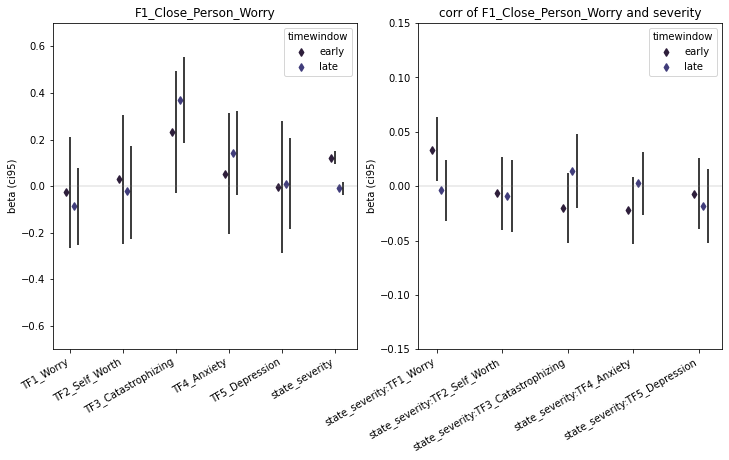

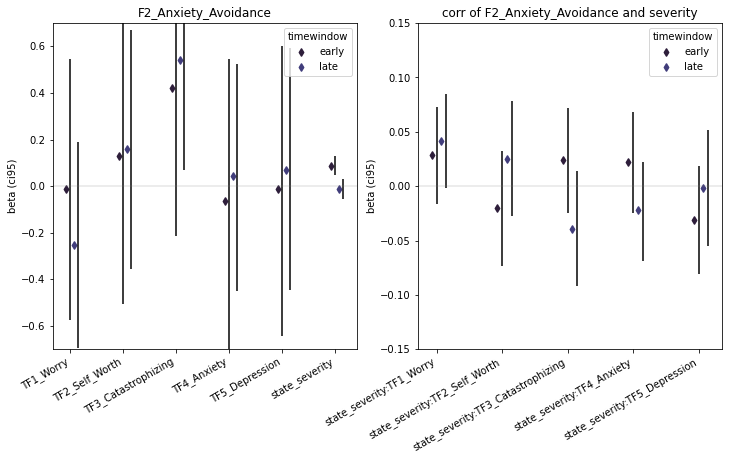

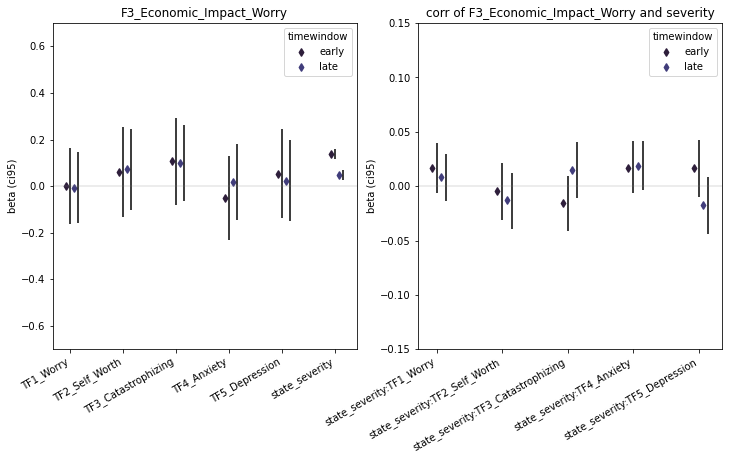

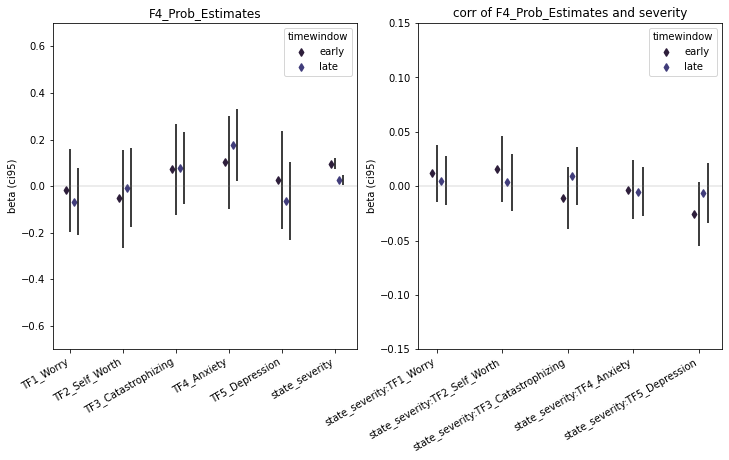

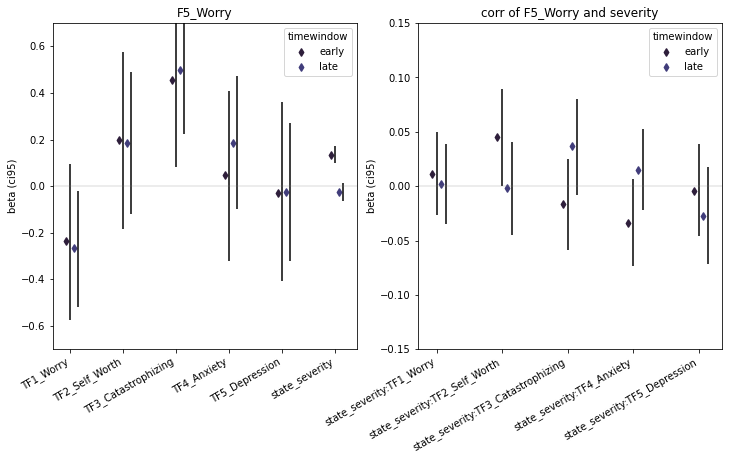

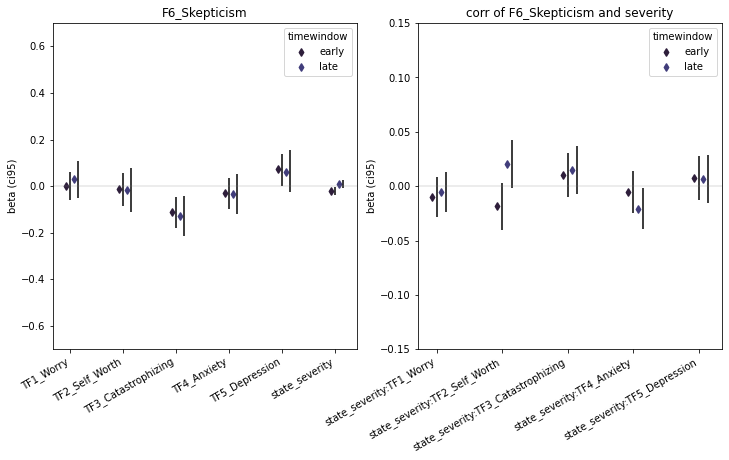

In [4]:
model_constant = "severity_noslope_"
ylims = [[-0.7,0.7], [-0.15, 0.15], [-0.02, 0.02]]
folder = "severity_timewindow"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"early_f5_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res,m  = mm.estimate_lmm(mod, [], override=0)
    display.display(az.summary(res).head(15))
    
    mod2 = models["F"+str(f_idx+1)+"_"+model_constant+"late_f5_4_3000"]
    # assumes that models have been estimated
    mod2["current_sys_location"] = os.path.join(root_dir, mod2["location"])
    mod2, res2,m  = mm.estimate_lmm(mod2, [], override=0)
    display.display(az.summary(res2).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            dt.loc[:,"timewindow"] = "early"
            tdf = pd.concat([tdf, dt])
            
            d = res2.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            dt.loc[:,"timewindow"] = "late"
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample", hue="timewindow", hue_order=["early", "late"],
                      data=tdf, dodge=0.15, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby(["trait_factor", "timewindow"])['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        for iidx, i in enumerate(["early", "late"]):    
            bounds_loc = bounds.loc[bounds["timewindow"].isin([i]),:]
            x_base = np.arange(len(bounds_loc.trait_factor))
            axs[gr_idx].vlines(x_base+0.15*iidx, bounds_loc.iloc[:,2], bounds_loc.iloc[:,3], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

In [ ]:
bounds = tdf.groupby(["trait_factor", "timewindow"])['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
bounds